<a href="https://colab.research.google.com/github/GOVINDFROMINDIA/Space-Paper/blob/main/A100/Large_UNet3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

In [ ]:
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 24.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5b8355245ec9d85c5e032580250f87840b438326b021c86c27f1b40e6bf72ebe
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=cef0658f230a193802dd24c3cbc62fab6ba59e46b2ad1f3e73b989c02aed0021
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
data_directory = '/content/drive/MyDrive/DATA'
import pandas as pd
metadata_path = f'{data_directory}/metadata.csv'
metadeep_path = f'{data_directory}/metadata1.csv'
metadata = pd.read_csv(metadata_path)
metadeep = pd.read_csv(metadeep_path)
metadata.head()

Mounted at /content/drive


,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,10078660_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif,png/train/10078660_15.png,png/train_labels/10078660_15.png
1,10078675_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif,png/train/10078675_15.png,png/train_labels/10078675_15.png
2,10078690_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078690_15.tiff,tiff/train_labels/10078690_15.tif,png/train/10078690_15.png,png/train_labels/10078690_15.png
3,10078705_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078705_15.tiff,tiff/train_labels/10078705_15.tif,png/train/10078705_15.png,png/train_labels/10078705_15.png
4,10078720_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078720_15.tiff,tiff/train_labels/10078720_15.tif,png/train/10078720_15.png,png/train_labels/10078720_15.png


In [ ]:
metadeep.head()


,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DATA')

In [ ]:
CSV1_FILE = '/content/drive/MyDrive/DATA/metadata.csv'
CSV2_FILE = '/content/drive/MyDrive/DATA/metadata1.csv'
DATA_DIR = '/content/drive/MyDrive/DATA/'

DEVICE = 'cuda'

EPOCHS = 50
LR = 0.003
BATCH_SIZE = 32
IMG_SIZE = 256

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV1_FILE)
df = df.rename(columns={'tiff_image_path': 'images', 'tif_label_path': 'masks'})
columns_to_drop = ['image_id','label_source_url', 'image_souce_url','png_image_path','split','png_label_path']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,images,masks
0,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif
1,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif
2,tiff/train/10078690_15.tiff,tiff/train_labels/10078690_15.tif
3,tiff/train/10078705_15.tiff,tiff/train_labels/10078705_15.tif
4,tiff/train/10078720_15.tiff,tiff/train_labels/10078720_15.tif


In [ ]:
df1 = pd.read_csv(CSV2_FILE)
df1 = df1.rename(columns={'sat_image_path': 'images', 'mask_path': 'masks'})
columns1_to_drop = ['image_id','split']
df1.drop(columns=columns1_to_drop, inplace=True)
df1 = df1.dropna()
df1.head()

,images,masks
0,train/100034_sat.jpg,train/100034_mask.png
1,train/100081_sat.jpg,train/100081_mask.png
2,train/100129_sat.jpg,train/100129_mask.png
3,train/100703_sat.jpg,train/100703_mask.png
4,train/100712_sat.jpg,train/100712_mask.png


In [ ]:
df1.count()


images    6226
masks     6226
dtype: int64

In [ ]:
df = pd.concat([df, df1], ignore_index=True)
df.count()

images    7397
masks     7397
dtype: int64

# **FIX THE DIRECTORY DETAILS ALSO**

In [ ]:
idx = 3

row_id = df.iloc[idx]

image_path =  DATA_DIR + row_id.images
mask_path = DATA_DIR + row_id.masks
print(image_path)

/content/drive/MyDrive/DATA/tiff/train/10078705_15.tiff


In [ ]:
image = cv2.imread(image_path)
if image is not None:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
else:
    print(f"Error loading image: {image_path}")
    # Handle the error, for example, by returning None or a default image

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255
if mask is None:
    print(f"Error loading mask: {mask_path}")
    # Handle the error, for example, by returning None or a default mask


Image Loaded: True
Mask Loaded: True


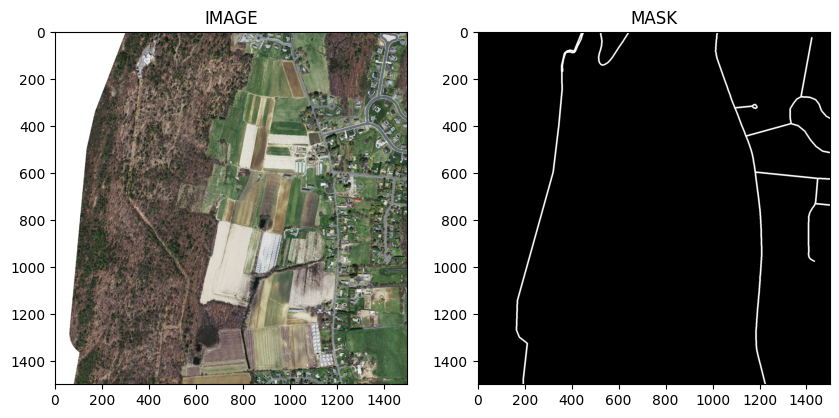

In [ ]:
print("Image Loaded:", image is not None)
print("Mask Loaded:", mask is not None)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('IMAGE')
if image is not None:
    ax1.imshow(image)
else:
    ax1.text(0.5, 0.5, "Image not loaded", ha='center', va='center', color='red')

ax2.set_title('MASK')
if mask is not None:
    if len(mask.shape) == 3:  # Checking for RGB masks (if applicable)
        ax2.imshow(mask)
    else:
        ax2.imshow(mask, cmap='gray')
else:
    ax2.text(0.5, 0.5, "Mask not loaded", ha='center', va='center', color='red')

plt.show()


In [ ]:
df_train, df_test = train_test_split(df, test_size = .08, random_state = 42)

In [ ]:
print(len(df_train), len(df_test))

6805 592


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-3kmav75g
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-3kmav75g
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_test_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row_id = self.df.iloc[idx]

    image_path = DATA_DIR + row_id.images
    mask_path = DATA_DIR + row_id.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #add the channel dimension to mask to add the channel dimension
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #change the image and mask format from h x w x c to c x h x w

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(df_train , get_train_augs())
testset = SegmentationDataset(df_test , get_test_augs())

In [ ]:
len(trainset)

6805

In [ ]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

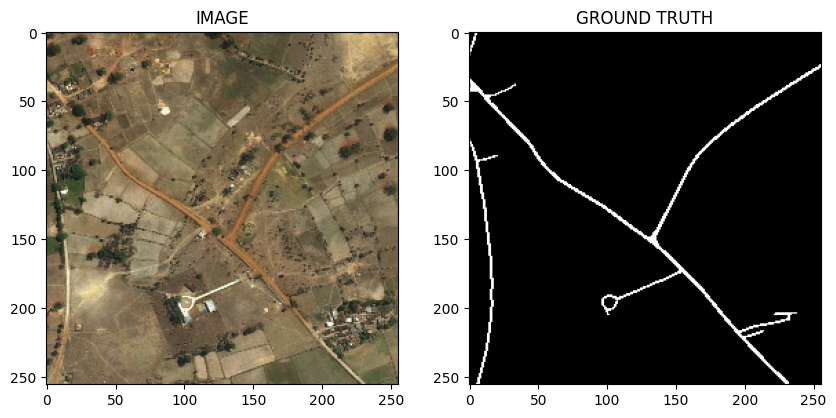

In [ ]:
idx = 400

image, mask = trainset[idx]

show_image(image,mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(trainset, batch_size = BATCH_SIZE)

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes =1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 306MB/s]


In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def test_fn(dataloader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
train_losses = []
test_losses = []
best_loss = np.Inf


for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    test_loss = test_fn(testloader, model)

    if test_loss < best_loss:
        # Save to local Colab session
        torch.save(model.state_dict(), "best-model.pt")

        # Save to Google Drive
        drive_path = "/content/drive/MyDrive/DATA/UNet-PRO3.pt"
        drive_path1 = "/content/drive/MyDrive/UNet-PRO3.pt"
        torch.save(model.state_dict(), drive_path)
        torch.save(model.state_dict(), drive_path1)

        print(f'Model Saved locally and to Google Drive at: {drive_path}')
        best_loss = test_loss

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch: {i+1}, Train loss: {train_loss}, Test loss: {test_loss}")

100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 1, Train loss: 0.7392165646866453, Test loss: 0.6180182216872632


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 2, Train loss: 0.5991228575437841, Test loss: 0.5906909922478905


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 3, Train loss: 0.568985448616771, Test loss: 0.5389315951877917


100%|██████████| 213/213 [04:19<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 4, Train loss: 0.5450893355087495, Test loss: 0.5282006578546175


100%|██████████| 213/213 [04:19<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 5, Train loss: 0.5310328164850602, Test loss: 0.5141046170337659


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Epoch: 6, Train loss: 0.5188069279205072, Test loss: 0.5231411012125687


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 7, Train loss: 0.5091025501909391, Test loss: 0.4966904937941144


100%|██████████| 213/213 [04:19<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 8, Train loss: 0.5003970563411713, Test loss: 0.48358184169155893


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Epoch: 9, Train loss: 0.4934943185445848, Test loss: 0.4973258598589561


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 10, Train loss: 0.48957638491487276, Test loss: 0.4729308846970679


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Epoch: 11, Train loss: 0.48434035389076374, Test loss: 0.4729991872825533


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 12, Train loss: 0.4780500454242241, Test loss: 0.46439764785095


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 13, Train loss: 0.47478517316316776, Test loss: 0.46296143699699727


100%|██████████| 213/213 [04:21<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 14, Train loss: 0.4692993911219315, Test loss: 0.4565628026852585


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 15, Train loss: 0.4647055465570638, Test loss: 0.45359893695849207


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Epoch: 16, Train loss: 0.4609537768252019, Test loss: 0.46216820831030186


100%|██████████| 213/213 [04:22<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 17, Train loss: 0.4575510945678317, Test loss: 0.4475991177446965


100%|██████████| 213/213 [04:22<00:00,  1.23s/it]


Epoch: 18, Train loss: 0.45784491286591184, Test loss: 0.4512995358364123


100%|██████████| 213/213 [04:23<00:00,  1.24s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 19, Train loss: 0.45247269558234954, Test loss: 0.44372812151349206


100%|██████████| 213/213 [04:23<00:00,  1.24s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 20, Train loss: 0.449073979132612, Test loss: 0.44229926063980857


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Epoch: 21, Train loss: 0.4547439223164124, Test loss: 0.4509771831438575


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 22, Train loss: 0.44913101406164574, Test loss: 0.4384707728741874


100%|██████████| 213/213 [04:19<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 23, Train loss: 0.443615241929399, Test loss: 0.43490017355887545


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 24, Train loss: 0.439583613419197, Test loss: 0.4303229700231776


100%|██████████| 213/213 [04:21<00:00,  1.23s/it]


Epoch: 25, Train loss: 0.4357380466841756, Test loss: 0.43235884571858973


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 26, Train loss: 0.43662470257338226, Test loss: 0.42741447225422924


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 27, Train loss: 0.43342150502921273, Test loss: 0.4253779183810865


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 28, Train loss: 0.43062250574989497, Test loss: 0.41956473460219834


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Epoch: 29, Train loss: 0.4287546828319209, Test loss: 0.4200448606495566


100%|██████████| 213/213 [04:21<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 30, Train loss: 0.42741285593297, Test loss: 0.41487480133352145


100%|██████████| 213/213 [04:21<00:00,  1.23s/it]


Epoch: 31, Train loss: 0.42383093691207996, Test loss: 0.41716081211824374


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 32, Train loss: 0.4230871315293469, Test loss: 0.41113677970680274


100%|██████████| 213/213 [04:21<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 33, Train loss: 0.4195340229591853, Test loss: 0.4107394484287137


100%|██████████| 213/213 [04:22<00:00,  1.23s/it]


Epoch: 34, Train loss: 0.41781365255794617, Test loss: 0.41138223583149797


100%|██████████| 213/213 [04:23<00:00,  1.24s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 35, Train loss: 0.41672923713222915, Test loss: 0.40585778716584325


100%|██████████| 213/213 [04:24<00:00,  1.24s/it]


Epoch: 36, Train loss: 0.417166810360313, Test loss: 0.4094217146786166


100%|██████████| 213/213 [04:23<00:00,  1.24s/it]


Epoch: 37, Train loss: 0.41419967841094646, Test loss: 0.4071720213117734


100%|██████████| 213/213 [04:23<00:00,  1.24s/it]


Epoch: 38, Train loss: 0.41232683065351744, Test loss: 0.416577719606704


100%|██████████| 213/213 [04:23<00:00,  1.24s/it]


Epoch: 39, Train loss: 0.41057884791087657, Test loss: 0.41067840277868817


100%|██████████| 213/213 [04:21<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 40, Train loss: 0.4092849800844148, Test loss: 0.4003486465400373


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Epoch: 41, Train loss: 0.4083506764380585, Test loss: 0.40422674327948843


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 42, Train loss: 0.4074004594708832, Test loss: 0.39511342843373615


100%|██████████| 213/213 [04:21<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 43, Train loss: 0.4058311062519539, Test loss: 0.39434117414581943


100%|██████████| 213/213 [04:23<00:00,  1.24s/it]


Epoch: 44, Train loss: 0.4036542855797799, Test loss: 0.3962759528081742


100%|██████████| 213/213 [04:22<00:00,  1.23s/it]


Epoch: 45, Train loss: 0.4030934562425658, Test loss: 0.396080108175815


100%|██████████| 213/213 [04:22<00:00,  1.23s/it]


Epoch: 46, Train loss: 0.40140758993480125, Test loss: 0.39464486218953915


100%|██████████| 213/213 [04:22<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 47, Train loss: 0.3993531473925416, Test loss: 0.3902456620489488


100%|██████████| 213/213 [04:20<00:00,  1.22s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 48, Train loss: 0.399264975612712, Test loss: 0.3887855390987486


100%|██████████| 213/213 [04:19<00:00,  1.22s/it]


Epoch: 49, Train loss: 0.3967065773379635, Test loss: 0.39402125349067185


100%|██████████| 213/213 [04:22<00:00,  1.23s/it]


Model Saved locally and to Google Drive at: /content/drive/MyDrive/DATA/UNet-PRO3.pt
Epoch: 50, Train loss: 0.3955889021007108, Test loss: 0.3874070448494853


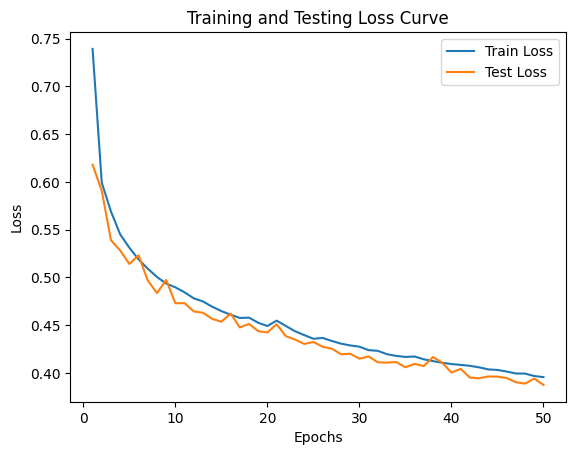

In [ ]:
epochs = range(1, EPOCHS+1)

plt.plot(epochs[:len(train_losses)], train_losses, label='Train Loss')
plt.plot(epochs[:len(test_losses)], test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curve')
plt.legend()
plt.show()

In [ ]:
idx = 36

model.load_state_dict(torch.load('/content/drive/MyDrive/UNet-PRO3.pt'))

image, mask = testset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

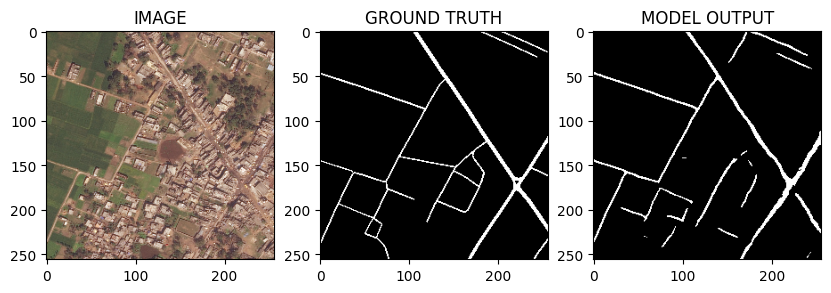

In [ ]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [ ]:
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

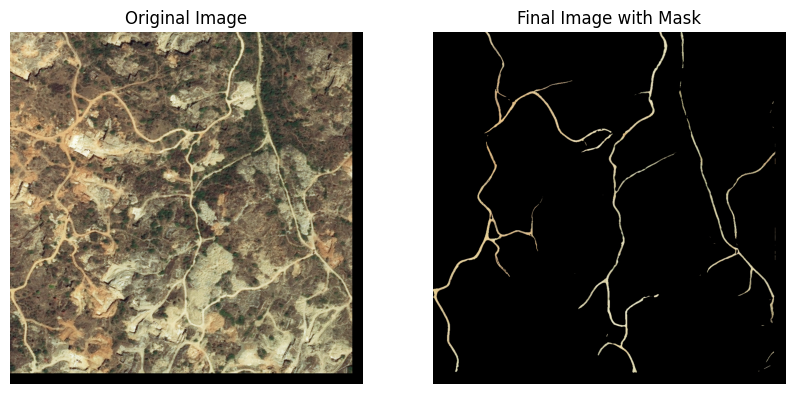

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed
])

# Load the image and apply the transformation
dsg = '/content/drive/MyDrive/DATA/test/104859_sat.jpg'
input_image = Image.open(dsg).convert('RGB')
input_image = transform(input_image)

# Pad the image to be divisible by 32
target_size = 32
h, w = input_image.shape[1:]
pad_h = (h // target_size + 1) * target_size - h
pad_w = (w // target_size + 1) * target_size - w
input_image = F.pad(input_image, (0, pad_w, 0, pad_h), mode='constant', value=0)

# Move to the appropriate device
input_image = input_image.unsqueeze(0).to(DEVICE)

# Make predictions
logits_mask = model(input_image)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5).float()

# Convert the tensors to numpy arrays
input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
pred_mask_np = pred_mask.squeeze(0).cpu().numpy()

# Display the original and final images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title('Original Image')
plt.axis('off')

# Final image with predicted mask overlay
final_mask = pred_mask_np.squeeze(0)[:, :, None]  # Add an extra dimension for the third channel
final_image = input_image_np * final_mask
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title('Final Image with Mask')
plt.axis('off')

plt.show()

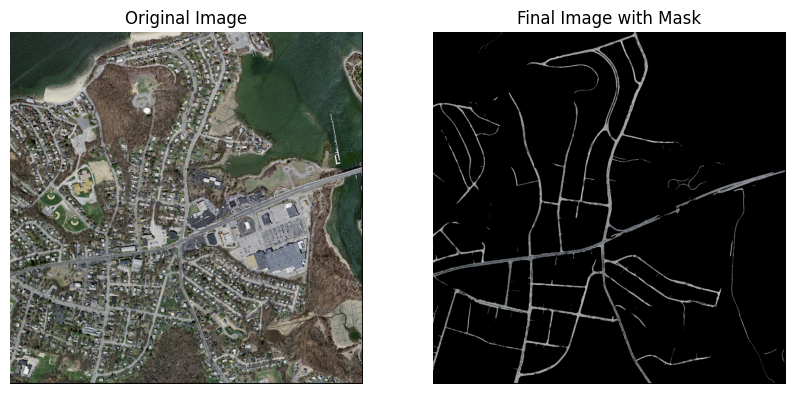

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed
])

# Load the image and apply the transformation
dsg = '/content/drive/MyDrive/DATA/tiff/test/24628885_15.tiff'
input_image = Image.open(dsg).convert('RGB')
input_image = transform(input_image)

# Pad the image to be divisible by 32
target_size = 32
h, w = input_image.shape[1:]
pad_h = (h // target_size + 1) * target_size - h
pad_w = (w // target_size + 1) * target_size - w
input_image = F.pad(input_image, (0, pad_w, 0, pad_h), mode='constant', value=0)

# Move to the appropriate device
input_image = input_image.unsqueeze(0).to(DEVICE)

# Make predictions
logits_mask = model(input_image)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5).float()

# Convert the tensors to numpy arrays
input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
pred_mask_np = pred_mask.squeeze(0).cpu().numpy()

# Display the original and final images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title('Original Image')
plt.axis('off')

# Final image with predicted mask overlay
final_mask = pred_mask_np.squeeze(0)[:, :, None]  # Add an extra dimension for the third channel
final_image = input_image_np * final_mask
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title('Final Image with Mask')
plt.axis('off')

plt.show()